In [ ]:
# Import relevant functionality
from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent

# Create the agent
memory = MemorySaver()
model = init_chat_model("anthropic:claude-3-5-sonnet-latest")
# search = TavilySearch(max_results=2)
# tools = [search]
# agent_executor = create_react_agent(model, tools, checkpointer=memory)

import networkx as nx
import matplotlib.pyplot as plt

def my_draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=None,
    label_pos=0.5,
    font_size=10,
    font_color="k",
    font_family="sans-serif",
    font_weight="normal",
    alpha=None,
    bbox=None,
    horizontalalignment="center",
    verticalalignment="center",
    ax=None,
    rotate=True,
    clip_on=True,
    rad=0
):
    """Draw edge labels.

    Parameters
    ----------
    G : graph
        A networkx graph

    pos : dictionary
        A dictionary with nodes as keys and positions as values.
        Positions should be sequences of length 2.

    edge_labels : dictionary (default={})
        Edge labels in a dictionary of labels keyed by edge two-tuple.
        Only labels for the keys in the dictionary are drawn.

    label_pos : float (default=0.5)
        Position of edge label along edge (0=head, 0.5=center, 1=tail)

    font_size : int (default=10)
        Font size for text labels

    font_color : string (default='k' black)
        Font color string

    font_weight : string (default='normal')
        Font weight

    font_family : string (default='sans-serif')
        Font family

    alpha : float or None (default=None)
        The text transparency

    bbox : Matplotlib bbox, optional
        Specify text box properties (e.g. shape, color etc.) for edge labels.
        Default is {boxstyle='round', ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0)}.

    horizontalalignment : string (default='center')
        Horizontal alignment {'center', 'right', 'left'}

    verticalalignment : string (default='center')
        Vertical alignment {'center', 'top', 'bottom', 'baseline', 'center_baseline'}

    ax : Matplotlib Axes object, optional
        Draw the graph in the specified Matplotlib axes.

    rotate : bool (deafult=True)
        Rotate edge labels to lie parallel to edges

    clip_on : bool (default=True)
        Turn on clipping of edge labels at axis boundaries

    Returns
    -------
    dict
        `dict` of labels keyed by edge

    Examples
    --------
    >>> G = nx.dodecahedral_graph()
    >>> edge_labels = nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G))

    Also see the NetworkX drawing examples at
    https://networkx.org/documentation/latest/auto_examples/index.html

    See Also
    --------
    draw
    draw_networkx
    draw_networkx_nodes
    draw_networkx_edges
    draw_networkx_labels
    """
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        ax = plt.gca()
    if edge_labels is None:
        labels = {(u, v): d for u, v, d in G.edges(data=True)}
    else:
        labels = edge_labels
    text_items = {}
    for (n1, n2), label in labels.items():
        (x1, y1) = pos[n1]
        (x2, y2) = pos[n2]
        (x, y) = (
            x1 * label_pos + x2 * (1.0 - label_pos),
            y1 * label_pos + y2 * (1.0 - label_pos),
        )
        pos_1 = ax.transData.transform(np.array(pos[n1]))
        pos_2 = ax.transData.transform(np.array(pos[n2]))
        linear_mid = 0.5*pos_1 + 0.5*pos_2
        d_pos = pos_2 - pos_1
        rotation_matrix = np.array([(0,1), (-1,0)])
        ctrl_1 = linear_mid + rad*rotation_matrix@d_pos
        ctrl_mid_1 = 0.5*pos_1 + 0.5*ctrl_1
        ctrl_mid_2 = 0.5*pos_2 + 0.5*ctrl_1
        bezier_mid = 0.5*ctrl_mid_1 + 0.5*ctrl_mid_2
        (x, y) = ax.transData.inverted().transform(bezier_mid)

        if rotate:
            # in degrees
            angle = np.arctan2(y2 - y1, x2 - x1) / (2.0 * np.pi) * 360
            # make label orientation "right-side-up"
            if angle > 90:
                angle -= 180
            if angle < -90:
                angle += 180
            # transform data coordinate angle to screen coordinate angle
            xy = np.array((x, y))
            trans_angle = ax.transData.transform_angles(
                np.array((angle,)), xy.reshape((1, 2))
            )[0]
        else:
            trans_angle = 0.0
        # use default box of white with white border
        if bbox is None:
            bbox = dict(boxstyle="round", ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0))
        if not isinstance(label, str):
            label = str(label)  # this makes "1" and 1 labeled the same

        t = ax.text(
            x,
            y,
            label,
            size=font_size,
            color=font_color,
            family=font_family,
            weight=font_weight,
            alpha=alpha,
            horizontalalignment=horizontalalignment,
            verticalalignment=verticalalignment,
            rotation=trans_angle,
            transform=ax.transData,
            bbox=bbox,
            zorder=1,
            clip_on=clip_on,
        )
        text_items[(n1, n2)] = t

    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )

    return text_items

{('user', 'chatbot'): Text(0.05942949912067941, 0.3354978354978353, 'ask'),
 ('chatbot',
  'user'): Text(-0.05942949912067952, -0.33549783549783574, 'response')}

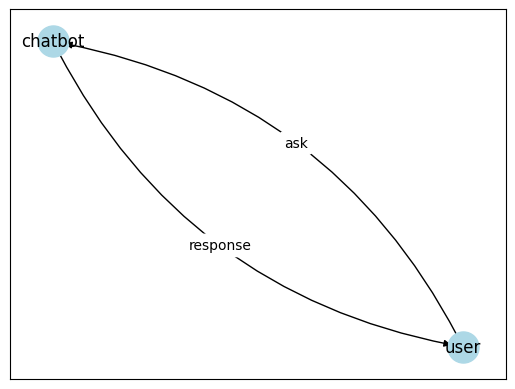

In [32]:
# Chatbot without RAG
G = nx.DiGraph()
edge_list = [('user','chatbot',{'w': 'ask'}),
             ('chatbot','user',{'w': 'response'})]
G.add_edges_from(edge_list)
pos = nx.spring_layout(G, seed=5)
fig, ax = plt.subplots()
nx.draw_networkx_nodes(G, pos, ax=ax, node_color='lightblue',node_size=500)
nx.draw_networkx_labels(G, pos, ax=ax)
curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
arc_rad = 0.25
nx.draw_networkx_edges(G, pos, ax=ax, edgelist=curved_edges,
                       connectionstyle=f'arc3, rad = {arc_rad}')

edge_weights = nx.get_edge_attributes(G, 'w')
curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
my_draw_networkx_edge_labels(G, pos, ax=ax,
                             edge_labels=curved_edge_labels, rotate=False,
                             rad=arc_rad)

# Summary: chatbot can respond to common questions but not with the latest or domain-specific knowledge
# Ex: What's my mother's name?


{('user', 'chatbot'): Text(-0.507736511059772, -0.018309906626825023, 'ask'),
 ('chatbot',
  'user'): Text(-0.4922326252305709, 0.03545867194388441, 'response'),
 ('chatbot',
  'knowledge base'): Text(0.4889253589369633, -0.03450337614670135, 'query'),
 ('knowledge base',
  'chatbot'): Text(0.5110746410630367, 0.019260224084264976, 'knowledge')}

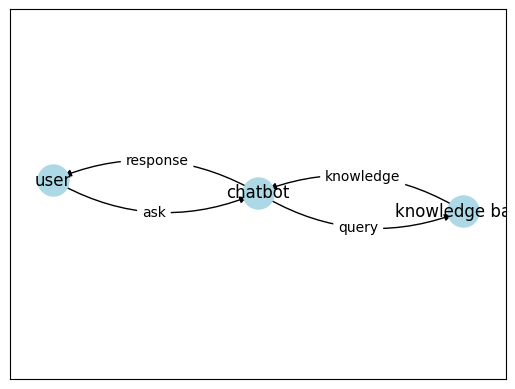

In [31]:
# RAG System
#
#  User
# |    \
# ask  response
# \     |
# chatbot LLM
# |       \
# query  knowledge
# \       |
# knowledge base
# (retrieval model)
edge_list2 = [('user','chatbot',{'w': 'ask'}),
              ('chatbot','user',{'w': 'response'}),
              ('chatbot','knowledge base',{'w': 'query'}),
              ('knowledge base','chatbot',{'w': 'knowledge'})]

G.add_edges_from(edge_list2)
pos = nx.spring_layout(G, seed=5)
fig, ax = plt.subplots()
nx.draw_networkx_nodes(G, pos, ax=ax, node_color='lightblue',node_size=500)
nx.draw_networkx_labels(G, pos, ax=ax)
curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
arc_rad = 0.25
nx.draw_networkx_edges(G, pos, ax=ax, edgelist=curved_edges,
                       connectionstyle=f'arc3, rad = {arc_rad}')

edge_weights = nx.get_edge_attributes(G, 'w')
curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
my_draw_networkx_edge_labels(G, pos, ax=ax,
                             edge_labels=curved_edge_labels, rotate=False,
                             rad=arc_rad)

In [36]:
# Simple RAG
# Embedding model: pre-trained model that converts inpuit to vector representations that capture semantics
# Vector db: storage system for knowledge
# Chatbot: language model generating responses
# Indexing: break dataset into small chunks and calculate vector

# bge-base-en-v1.5 for embedding
# Llama-3.2-1B-Instruct for language

# Loading dataset
dataset = []
with open('cat-facts.txt', 'r') as file:
  dataset = file.readlines()
  print(f'Loaded {len(dataset)} entries')

# Vector db
import ollama

EMBEDDING_MODEL = 'hf.co/CompendiumLabs/bge-base-en-v1.5-gguf'
LANGUAGE_MODEL = 'hf.co/bartowski/Llama-3.2-1B-Instruct-GGUF'

# Elements are tuples (chunk, embedding)
# Embeddings are float lists
VECTOR_DB = []
def add_chunk_to_database(chunk):
  embedding = ollama.embed(model=EMBEDDING_MODEL, input=chunk)['embeddings'][0]
  VECTOR_DB.append((chunk, embedding))

# each line is a chunk for simplicity
for i, chunk in enumerate(dataset):
  add_chunk_to_database(chunk)
  print(f'Added chunk {i+1}/{len(dataset)} to the database')

# similarity between vectors
def cosine_similarity(a, b):
  dot_product = sum([x * y for x, y in zip(a, b)])
  norm_a = sum([x ** 2 for x in a]) ** 0.5
  norm_b = sum([x ** 2 for x in b]) ** 0.5
  return dot_product / (norm_a * norm_b)

# retrieval function
def retrieve(query, top_n=3):
  query_embedding = ollama.embed(model=EMBEDDING_MODEL, input=query)['embeddings'][0]
  # temporary list to store (chunk, similarity) pairs
  similarities = []
  for chunk, embedding in VECTOR_DB:
    similarity = cosine_similarity(query_embedding, embedding)
    similarities.append((chunk, similarity))
  # sort by similarity in descending order, because higher similarity means more relevant chunks
  similarities.sort(key=lambda x: x[1], reverse=True)
  # finally, return the top N most relevant chunks
  return similarities[:top_n]

# generation phase
input_query = input('Ask me a question: ')
retrieved_knowledge = retrieve(input_query)

print('Retrieved knowledge:')
for chunk, similarity in retrieved_knowledge:
  print(f' - (similarity: {similarity:.2f}) {chunk}')

instruction_prompt = f'''You are a helpful chatbot.
Use only the following pieces of context to answer the question. Don't make up any new information:
'''
for chunk, similarity in retrieved_knowledge:
    print(f' - {chunk}')


# ollama chatbot
stream = ollama.chat(
  model=LANGUAGE_MODEL,
  messages=[
    {'role': 'system', 'content': instruction_prompt},
    {'role': 'user', 'content': input_query},
  ],
  stream=True,
)

# print the response from the chatbot in real-time
print('Chatbot response:')
for chunk in stream:
  print(chunk['message']['content'], end='', flush=True)


Loaded 150 entries
Added chunk 1/150 to the database
Added chunk 2/150 to the database
Added chunk 3/150 to the database
Added chunk 4/150 to the database
Added chunk 5/150 to the database
Added chunk 6/150 to the database
Added chunk 7/150 to the database
Added chunk 8/150 to the database
Added chunk 9/150 to the database
Added chunk 10/150 to the database
Added chunk 11/150 to the database
Added chunk 12/150 to the database
Added chunk 13/150 to the database
Added chunk 14/150 to the database
Added chunk 15/150 to the database
Added chunk 16/150 to the database
Added chunk 17/150 to the database
Added chunk 18/150 to the database
Added chunk 19/150 to the database
Added chunk 20/150 to the database
Added chunk 21/150 to the database
Added chunk 22/150 to the database
Added chunk 23/150 to the database
Added chunk 24/150 to the database
Added chunk 25/150 to the database
Added chunk 26/150 to the database
Added chunk 27/150 to the database
Added chunk 28/150 to the database
Added chun

Ask me a question:  tell me about cat speed


Retrieved knowledge:
 - (similarity: 0.78) A cat can travel at a top speed of approximately 31 mph (49 km) over a short distance.

 - (similarity: 0.66) Cats are extremely sensitive to vibrations. Cats are said to detect earthquake tremors 10 or 15 minutes before humans can.

 - (similarity: 0.66) Researchers are unsure exactly how a cat purrs. Most veterinarians believe that a cat purrs by vibrating vocal folds deep in the throat. To do this, a muscle in the larynx opens and closes the air passage about 25 times per second.

 - A cat can travel at a top speed of approximately 31 mph (49 km) over a short distance.

 - Cats are extremely sensitive to vibrations. Cats are said to detect earthquake tremors 10 or 15 minutes before humans can.

 - Researchers are unsure exactly how a cat purrs. Most veterinarians believe that a cat purrs by vibrating vocal folds deep in the throat. To do this, a muscle in the larynx opens and closes the air passage about 25 times per second.

Chatbot respon